**Text Classification**

In [1]:
#pip install pyLDAvis

In [2]:
#pip install nltk gensim

In [3]:
#!pip uninstall numpy
#pip install numpy

In [4]:
#pip install --upgrade numpy

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import gensim
from gensim import corpora, models

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fayea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fayea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  # Optional, but will test later

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
import pandas as pd
import numpy as np

In [8]:
#stopwords = nltk.corpus.stopwords.words('english')
data_i3 = pd.read_excel('I3 Students Training Data Set.xlsx')

In [9]:
data_i3.head()

,db_id,query,question
0,ManualWater,"select meter_id , sum ( total_usage ) total_us...",what were my top 10 largest usage water meters...
1,ManualWater,select count(distinct meter_id) from meter_loc...,how many water meters are there
2,ManualWater,"select read_month , location_class , sum ( tot...",show me the total gallons of water used each m...
3,ManualWater,"select location_class , sum ( total_usage ) to...",what is the water usage for each location clas...
4,ManualWater,select location_class from location_class_usag...,which location class uses the most water


**EDA**


In [10]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
data_i3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   db_id     3808 non-null   object
 1   query     3807 non-null   object
 2   question  3808 non-null   object
dtypes: object(3)
memory usage: 89.4+ KB


In [12]:
data_i3[data_i3.isnull().any(axis=1)]

,db_id,query,question
3263,smartworks,NaN,list all meters where the address starts with ...


- The dataset has one null value found in row 3263.

In [13]:
data_i3.loc[3263, 'question']

'list all meters where the address starts with 600 Cherry Ave'

In [14]:
data_i3[data_i3['question'] == 'list all meters where the address starts with 600 Cherry Ave']

,db_id,query,question
3245,smartworks,select * from meter_location_details where upp...,list all meters where the address starts with ...
3246,smartworks,select * from meter_location_details where upp...,list all meters where the address starts with ...
3263,smartworks,NaN,list all meters where the address starts with ...


In [15]:
data_i3.loc[3245, 'query']

"select * from meter_location_details where upper ( address ) like upper ( '600 Cherry Ave%' )"

In [16]:
data_i3.loc[3246, 'query']

"select * from meter_location_details where upper ( address ) like upper ( '600 Cherry Ave%' )"

- here we have seen 3 rows in our dataset of the same question, so we might use this query to impute the lone null value in the query column

In [17]:
# will assign same query above to the null value at row 3263
data_i3.loc[3263, 'query'] = "select * from meter_location_details where upper ( address ) like upper ( '600 Cherry Ave%' )"

In [18]:
data_i3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   db_id     3808 non-null   object
 1   query     3808 non-null   object
 2   question  3808 non-null   object
dtypes: object(3)
memory usage: 89.4+ KB


In [19]:
data_i3['question'].apply(type).value_counts()

question
<class 'str'>    3807
<class 'int'>       1
Name: count, dtype: int64

- There is one column with int value in the question column, we need to change this to its appropriate question

In [20]:
# Create a boolean mask to identify rows with integer values in 'question' column
mask = data_i3['question'].apply(lambda x: isinstance(x, int))

# Use the mask to filter the DataFrame and locate the rows
rows_with_int_values = data_i3[mask]

In [21]:
rows_with_int_values

,db_id,query,question
3103,smartworks,select * from meter_location_details where met...,87010662


In [22]:
data_i3.loc[3103, 'query']

"select * from meter_location_details where meter_id = '87010662'"

In [23]:
# Define a regular expression pattern to match the query
pattern = r"select \* from meter_location_details where meter_id\s*="

data_i3[data_i3['query'].str.contains(pattern, case=False, na=False, regex=True)]

,db_id,query,question
3098,smartworks,select * from meter_location_details where met...,search for meter N53117468
3099,smartworks,select * from meter_location_details where met...,search for meter I506 000923
3103,smartworks,select * from meter_location_details where met...,87010662
3134,smartworks,select * from meter_location_details where met...,please show me location summary for meter 4099...
3152,smartworks,select * from meter_location_details where met...,show me the summary page for meter 87105167
3203,smartworks,select * from meter_location_details where met...,find meter 0275 119476
3206,smartworks,select * from meter_location_details where met...,please show me meter 0275 119476


- the customer is searching for this particular meter number by just typing it without additional question, which could sometimes be the case. So we will not change anything here. Instead, we'll just convert this to string to have a uniform type in this column

In [24]:
# Convert the 'question' column element in row 3103 to a string
data_i3.loc[3103, 'question'] = str(data_i3.loc[3103, 'question'])

In [25]:
data_i3['question'].apply(type).value_counts()

question
<class 'str'>    3808
Name: count, dtype: int64

- our data now has no more null, so we can now proceed with preprocessing

## Data Cleaning and Preprocessing

### Normalization, Tokenization, and  Lemmatization
- Properly remove punctuations, stopwords
- Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning.  
- Lemmatization is a text pre-processing technique used in natural language processing (NLP) models to break a word down to its root meaning to identify similarities. For example, a lemmatization algorithm would reduce the word better to its root word, or lemme, good. 

In [26]:
def preprocess_text(text, perform_stemming=False):
    
    text = re.sub(r'[^\w\s]', '', text) # removing punctuation and special characters
    text = text.lower()      # normalization 
    words = nltk.word_tokenize(text)   # tokenization
    
    stop_words = set(stopwords.words('english'))   # removing stopwords and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # Optionally, perform stemming
    if perform_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
   
    cleaned_text = ' '.join(words) # join the cleaned words back into a single string
    
    return cleaned_text

In [27]:
data_i3['cleaned'] = data_i3['question'].apply(preprocess_text)

In [28]:
# Text preprocessiong libraries

from nltk.corpus import stopwords
import nltk

# Make sure the stopwords are downloaded
nltk.download('stopwords')

# Load the English stopwords
stopwords = set(stopwords.words('english'))
wn = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fayea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def custom_lemmatizer(word):
    if word == "uses":
        return "use"
    elif word == "less":
        return word
    elif re.match(r'^[bcdfghjklmnpqrstvwxyz]+$', word):
        return word  # return the original word if it consists only of consonants
   # elif word in ['average', 'total', 'top', 'largest']:
   #     return ""
    elif re.match(r'^jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?$', word, re.IGNORECASE):
        return "month"
    else:
        return wn.lemmatize(word)

In [30]:
def clean_message(message, stopwords):
    message = re.sub(r'[^a-zA-Z_\s]', '', message)  # Remove non-alphabet characters except underscore
    message = ' '.join([word for word in message.split() if not word.isdigit()])  # Remove numeric values    
    return message

In [31]:
data_i3['cleaned'] = data_i3['cleaned'].apply(lambda x: clean_message(x, stopwords))
data_i3['lemmatized'] = data_i3['cleaned'].apply(lambda x: ' '.join([custom_lemmatizer(w) for w in x.split() if w not in stopwords]))

In [32]:
# Saving as CSV file in the same directory as this Python file

data_i3.to_csv("data_i3_cleaned.csv", index=False)

#### We will be using this cleaned data in the next step

### Word Cloud: common words in the question column

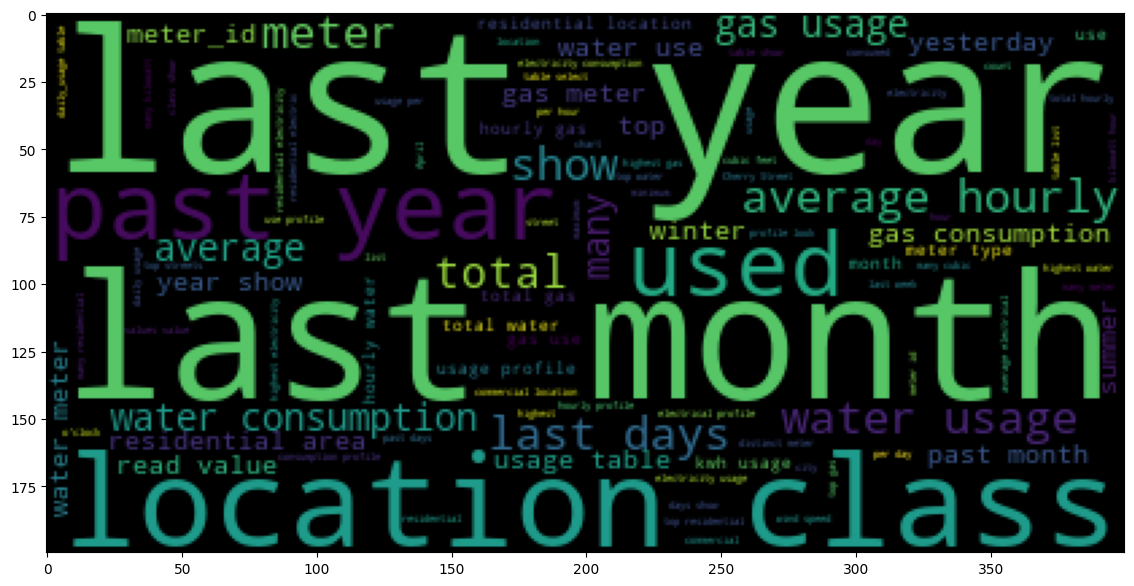

In [33]:
#word cloud visualization for the text
from wordcloud import WordCloud #visualization techniques for #frequently repeated texts

wcnt = WordCloud(
    background_color='black',
    max_words = 100,
    random_state = 42,
    max_font_size=90
    )

wcnt.generate(' '.join(data_i3['question']))
plt.figure(figsize=(30,7))
plt.imshow(wcnt)
plt.show()